#                            Stock Analysis and Price Prediction

# Contents
    1. Introduction
    2. Importing libraries
    3. Reading datasets
    4. Building Models
    5. Conclusion

# Introduction
In this project we will show how to write a python program that predicts the price of stocks using a machine learning technique called Long Short-Term Memory (LSTM) as well as create a optimize portfoilo using Efficient Frontier.

We will be solve the following question:

1. What was the change in price of the stock over time?
2. What was the monthly return of the stock on average?
3. What was the moving average of the various stocks?
4. What was the correlation between different stocks'?
5. How much value do we put at risk by investing in a particular stock?
6. Portfoilo optimization using Efficient Frontier?
7. How can we attempt to predict future stock behavior using LSTM?

# Importing Libraries

In [1]:
# here we are importing important libraries
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import tensorflow as tf

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from pandas_datareader import data as web
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from sklearn import metrics


plt.style.use("Solarize_Light2")
sns.set_style('whitegrid')
%matplotlib inline

# Reading Dataset

Companies names and thier Ticker that we used for our Analysis
    
    1. Apple Inc. = AAPL
    2. Alphabet Inc. = GOOG
    3. Microsoft Corporation = MSFT
    4. Amazon = AMZN
    5. Facebook Inc. = FB
    6. Alibaba Group = BABA
    7. Johnson & Johnson = JNJ
    8. JPMorgon Chase & Co. = JPM
    9. ExxonMobil = XOM
    10.Bank of America = BAC
    11.WalMart Store Inc. = WMT
    12.Wells Fargo & Co. = WFC
    13.Visa Inc. = V
    14.Procter & Gamble Co. = PG
    15.Verizon Communication = VZ
    16.AT&T Inc. = T
    17.UnitedHealth Group Inc. = UNH
    18.Home Depot = HD
    19.Intel = INTC
    20.Oracle = ORCL


1. What was the change in price of the stock over time?

In [2]:
#List of ticker of companies
ticker_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'FB', 'BABA','JNJ', 'JPM', 'XOM', 'BAC', 'WMT', 'WFC', 'V', 'PG', 'VZ', 'T', 'UNH', 'HD', 'INTC', 'ORCL']
data = pdr.get_data_yahoo(ticker_list, start = '2015-01-01')
data.tail()

Attributes   Adj Close                                                    \
Symbols           AAPL         GOOG        MSFT         AMZN          FB   
Date                                                                       
2020-11-11  119.489998  1752.709961  216.550003  3137.389893  276.480011   
2020-11-12  119.209999  1749.839966  215.440002  3110.280029  275.079987   
2020-11-13  119.260002  1777.020020  216.509995  3128.810059  276.950012   
2020-11-16  120.300003  1781.380005  217.229996  3131.060059  278.959991   
2020-11-17  120.490097  1775.699951  215.600098  3156.885010  275.850006   

Attributes                                                            ...  \
Symbols           BABA         JNJ         JPM        XOM        BAC  ...   
Date                                                                  ...   
2020-11-11  265.649994  147.800003  114.779999  36.480000  27.340000  ...   
2020-11-12  264.309998  148.300003  113.370003  35.230000  26.690001  ...   
2020-11-13  260.839996  149.899994  114.080002  36.080002  27.000000  ...   
2020-11-16  258.309998  150.850006  117.300003  38.160000  27.580000  ...   
2020-11-17  257.035004  150.115005  115.949997  38.505001  27.525000  ...   

Attributes      Volume                                                 \
Symbols            WMT         WFC           V         PG          VZ   
Date                                                                    
2020-11-11   6268600.0  38309200.0   5337200.0  5554300.0  12196900.0   
2020-11-12   4188100.0  34505900.0   7302500.0  5631700.0  13293300.0   
2020-11-13   6579400.0  30056100.0   6377500.0  6466800.0  10652800.0   
2020-11-16  11438000.0  36924800.0  12081800.0  7976600.0  14276300.0   
2020-11-17   9703214.0  18033468.0   3106063.0  3511926.0   5674893.0   

Attributes                                                           
Symbols              T        UNH         HD        INTC       ORCL  
Date                                                                 
2020-11-11  39718800.0  2048200.0  2987900.0  31496900.0  7724400.0  
2020-11-12  30473300.0  2907300.0  3818600.0  42881300.0  7324000.0  
2020-11-13  27470200.0  2442100.0  3939200.0  30884700.0  5870300.0  
2020-11-16  49911400.0  2790100.0  5337400.0  36283700.0  6308000.0  
2020-11-17  13675424.0  1272719.0  5907548.0  15905757.0  2798105.0  

[5 rows x 120 columns]

In [3]:
# Getting Monthly Adjused Close of all companies
monthly_adjusted_close = data['Adj Close'].resample('M').ffill()
monthly_adjusted_close.head()

Symbols,AAPL,GOOG,MSFT,AMZN,FB,BABA,JNJ,JPM,XOM,BAC,WMT,WFC,V,PG,VZ,T,UNH,HD,INTC,ORCL
Date,,,,,,,,,,,,,,,,,,,,
2015-01-31,26.465057,533.056519,35.983208,354.529999,75.910004,89.080002,85.573952,46.027359,66.733025,13.649244,73.640938,42.770687,61.054321,70.756332,35.313831,23.791393,96.975800,91.611542,28.040426,38.178539
2015-02-28,29.132116,556.871094,39.333977,380.160004,78.970001,85.120003,88.212410,51.867531,68.096741,14.243868,72.731041,45.432430,65.100479,71.461449,38.203213,24.976627,103.711617,100.674446,28.421066,39.937538
2015-03-31,28.218189,546.499573,36.472504,372.100006,82.220001,83.239998,86.568802,51.275059,65.374107,13.908826,71.703300,45.109032,62.780144,68.783653,37.569717,23.596268,108.326088,100.187141,26.728615,39.326889
2015-04-30,28.381468,537.340027,43.630669,421.779999,78.769997,81.290001,85.364075,53.899288,67.196884,14.396860,68.041862,45.689484,63.394428,67.280663,39.407963,25.394379,102.016464,94.340485,27.822720,39.894619
2015-05-31,29.668266,532.109985,42.307163,429.230011,79.190002,89.320000,86.801384,56.046398,66.069901,14.911998,65.155190,46.717010,66.034035,66.332932,38.626678,25.321066,110.084366,98.255898,29.668322,39.775715


In [4]:
#Here is quick summary of each company Monthly Adjusted closing
monthly_adjusted_close.describe()

Symbols,AAPL,GOOG,MSFT,AMZN,FB,BABA,JNJ,JPM,XOM,BAC,WMT,WFC,V,PG,VZ,T,UNH,HD,INTC,ORCL
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,45.719415,1002.072495,96.161003,1368.072322,157.725071,149.073028,117.347285,84.871481,63.330282,22.407953,86.367872,43.876609,120.563055,88.253679,46.563393,29.483654,197.667718,164.446494,40.267152,44.986852
std,24.893991,298.429565,52.335330,777.088881,50.019133,60.020521,19.877440,23.429921,10.512013,6.281727,24.843237,8.155589,46.823339,22.120152,7.440302,3.169749,69.263323,51.434760,10.733829,7.244110
min,21.652395,520.510010,35.983208,354.529999,75.910004,58.970001,81.534782,46.027359,31.851534,11.417576,50.558086,21.351967,61.054321,60.289993,34.394016,23.596268,96.975800,91.611542,24.775625,33.158382
25%,27.479910,758.459991,51.744623,736.329987,118.000000,88.445000,101.579391,58.252266,62.243469,15.303787,65.083275,42.543207,75.869396,71.465218,41.177639,27.531026,129.450119,119.403103,30.655752,38.099308
50%,39.952976,1021.409973,82.205322,1176.750000,164.460007,164.759995,121.332458,92.036423,66.649574,23.700001,81.947502,45.584629,111.854652,79.183121,44.657658,29.177425,211.202835,167.182297,42.449692,45.797440
75%,52.422976,1190.974976,130.119598,1790.775024,189.269997,185.550003,131.020203,101.568729,70.301388,27.655535,103.525887,48.868793,161.515877,104.116669,53.237133,31.871772,247.919510,196.570534,48.475605,50.750965
max,128.817749,1775.699951,225.529999,3450.959961,293.200012,304.690002,153.410004,134.515091,75.311615,34.513897,151.713196,59.070923,211.671066,142.960007,60.773300,36.577629,350.959991,283.544739,62.378933,59.459236


In [5]:
# Getting Monthly volume of all companies
monthly_volume = data['Volume'].resample('M').ffill()
monthly_volume.head()

Symbols,AAPL,GOOG,MSFT,AMZN,FB,BABA,JNJ,JPM,XOM,BAC,WMT,WFC,V,PG,VZ,T,UNH,HD,INTC,ORCL
Date,,,,,,,,,,,,,,,,,,,,
2015-01-31,334982000.0,5606300.0,78004900.0,23856100.0,42649500.0,36806900.0,10676300.0,26943700.0,22679900.0,99844600.0,10280200.0,21754800.0,22151600.0,14685300.0,22768000.0,56280900.0,5397500.0,7000000.0,38719700.0,22590000.0
2015-02-28,248059200.0,2410100.0,33807700.0,2532300.0,30739200.0,8377200.0,8500000.0,15225900.0,13090600.0,130448200.0,5877400.0,12937000.0,7965200.0,7685000.0,17571200.0,19863600.0,4016400.0,5732600.0,24427300.0,9549500.0
2015-03-31,168362400.0,1588000.0,34887200.0,2506100.0,19734300.0,11812900.0,8028000.0,17346700.0,13354000.0,61381700.0,5587700.0,13306200.0,7400500.0,8649700.0,12785700.0,27900200.0,4573100.0,4128800.0,32098500.0,13264200.0
2015-04-30,332781600.0,2082200.0,64725500.0,3647900.0,28999000.0,14209700.0,10170600.0,16840900.0,13947700.0,78313900.0,8795900.0,16577800.0,11780600.0,9409300.0,15604900.0,29693200.0,6705600.0,9041600.0,22013300.0,20196300.0
2015-05-31,203538000.0,2597400.0,36519600.0,3016100.0,16134600.0,13893200.0,9957800.0,14310700.0,14631300.0,74266200.0,6375100.0,17291500.0,6678100.0,12551700.0,14778400.0,29885100.0,6019900.0,5310600.0,43545500.0,10358700.0


2. What was the monthly return of the stock on average?

In [6]:
# Calculating monthly return
monthly_returns = data['Adj Close'].resample('M').ffill().pct_change()
monthly_returns.tail()

Symbols,AAPL,GOOG,MSFT,AMZN,FB,BABA,JNJ,JPM,XOM,BAC,WMT,WFC,V,PG,VZ,T,UNH,HD,INTC,ORCL
Date,,,,,,,,,,,,,,,,,,,,
2020-07-31,0.165132,0.049059,0.007371,0.147114,0.117144,0.163746,0.036479,0.037441,-0.059034,0.047579,0.080314,-0.052344,-0.014340,0.103516,0.054335,-0.004507,0.026547,0.059798,-0.202240,0.007498
2020-08-31,0.216569,0.101972,0.102752,0.090461,0.155832,0.143455,0.059489,0.036734,-0.032131,0.034566,0.077441,-0.000438,0.115076,0.054988,0.031141,0.007776,0.032268,0.073638,0.074713,0.031921
2020-09-30,-0.102526,-0.100711,-0.067397,-0.087579,-0.106753,0.024214,-0.029529,-0.039126,-0.140461,-0.057583,0.007634,-0.026501,-0.056701,0.004771,0.003712,-0.043610,0.001615,-0.020578,0.016290,0.043341
2020-10-31,-0.060012,0.103028,-0.037370,-0.035754,0.004620,0.036431,-0.079057,0.027836,-0.049811,-0.016189,-0.008291,-0.087622,-0.091314,-0.008121,-0.031824,-0.034836,-0.021266,-0.039610,-0.144844,-0.056328
2020-11-30,0.108745,0.095428,0.064850,0.039766,0.048421,-0.156405,0.094851,0.182680,0.208890,0.161392,0.093428,0.168276,0.165862,0.042743,0.066385,0.072720,0.150160,0.016891,0.041736,0.021119


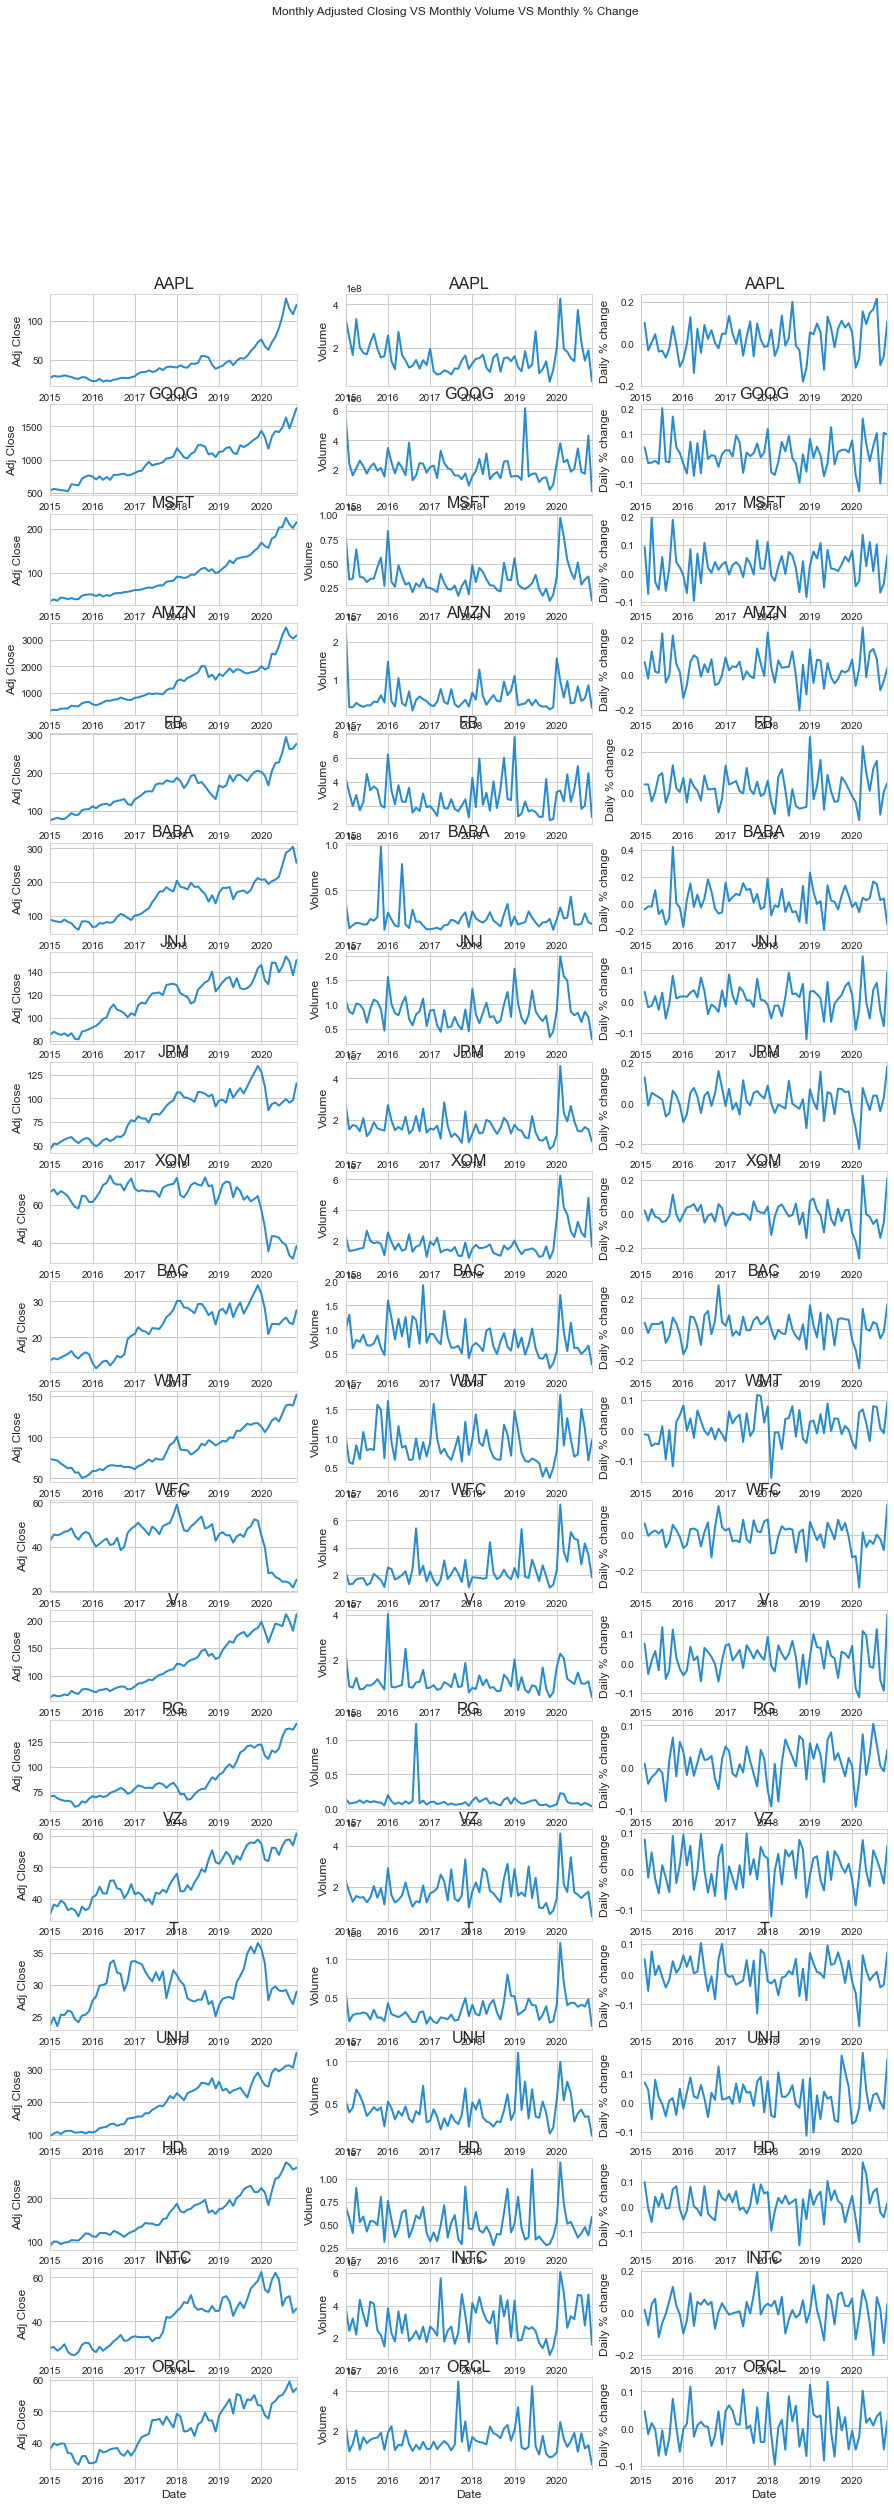

In [7]:
# here we are visualising of Monthly Adjusted Price, Monthly Volume and Monthly % Change

fig, axes = plt.subplots(nrows = 20, ncols = 3)
fig.suptitle('Monthly Adjusted Closing VS Monthly Volume VS Monthly % Change')
fig.set_figheight(40)
fig.set_figwidth(15)
#plt.subplots_adjust(top=2.25, bottom=2.2)

columns = list(monthly_adjusted_close) 
  
for i, cols in enumerate(columns,0):
    monthly_adjusted_close[cols].plot(ax = axes[i,0])
    axes[i,0].set(xlabel='Date', ylabel='Adj Close')
    axes[i,0].set_title(f"{ticker_list[i]}")
    monthly_volume[cols].plot(ax = axes[i,1])
    axes[i,1].set(xlabel='Date', ylabel='Volume')
    axes[i,1].set_title(f"{ticker_list[i]}")
    monthly_returns[cols].plot(ax = axes[i,2])
    axes[i,2].set(xlabel='Date', ylabel='Daily % change')
    axes[i,2].set_title(f"{ticker_list[i]}")

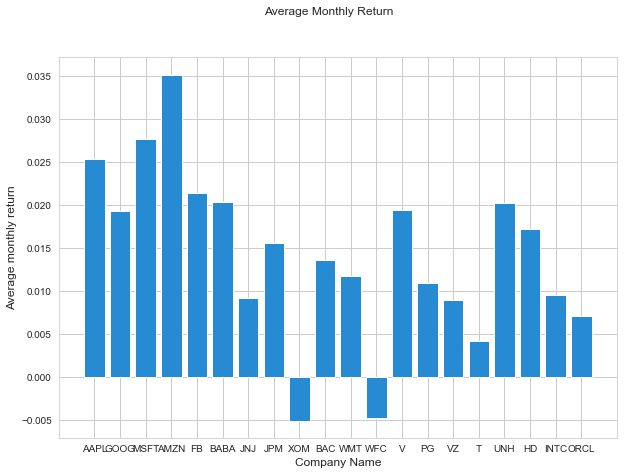

In [8]:
plt.figure(figsize=(10, 7))
plt.bar(columns, monthly_returns.mean())
plt.xlabel('Company Name')
plt.ylabel('Average monthly return')
plt.suptitle('Average Monthly Return')
plt.show()

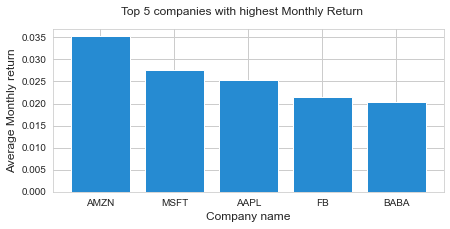

In [9]:
top_five = monthly_returns.mean().nlargest(5)
company_name = list(top_five.keys())
plt.figure(figsize=(7, 3))
plt.bar(company_name, top_five)
plt.suptitle('Top 5 companies with highest Monthly Return')
plt.ylabel('Average Monthly return')
plt.xlabel('Company name')
plt.show()

Now that we've brock down our companies from 20 to 5 on the basic of average percentage change in stock price and also seen the visualizations for the Adjusted price and the volume traded each day with daily percentage change, let's go ahead and caculate the moving average for the stock.

3. What was the moving average of the various stocks?

There are three important moving averages that we have applied to our charts so that it will help us to trade better. They are the 10 moving average, the 20 moving average and the 50 moving average. The 20 moving average (10MA) is the short-term outlook. The 50 moving average (20MA) is the medium term outlook. The 200 moving average (50MA) is the trend bias

In [10]:
# now we are using for loop for grabing yahoo data and setting it in form of dataframe
#  Using globals() is a sloppy way of setting the DataFrame names, but its simple
for stock in company_name:
    globals()[stock] = web.DataReader(stock,"yahoo",'2013-01-01',datetime.now())


In [11]:
company_list = [AMZN,MSFT,AAPL,FB,BABA]
for company, comp_name in zip(company_list,company_name):
    company["company_name"] = comp_name
    
company_data = pd.concat(company_list,axis=0)
company_data.tail(5)

,High,Low,Open,Close,Volume,Adj Close,company_name
Date,,,,,,,
2020-11-11,271.920013,261.204987,261.920013,265.649994,41699000.0,265.649994,BABA
2020-11-12,271.200012,263.040009,271.040009,264.309998,27119100.0,264.309998,BABA
2020-11-13,265.440002,257.170013,264.720001,260.839996,33942800.0,260.839996,BABA
2020-11-16,262.570007,257.029999,260.420013,258.309998,20820000.0,258.309998,BABA
2020-11-17,260.279999,256.549988,260.279999,257.059998,13200636.0,257.059998,BABA


In [12]:

ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()

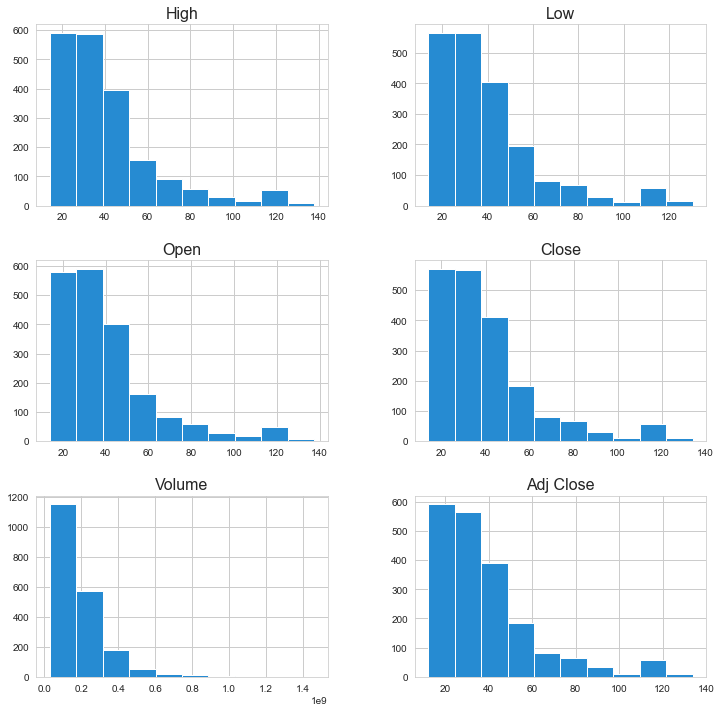

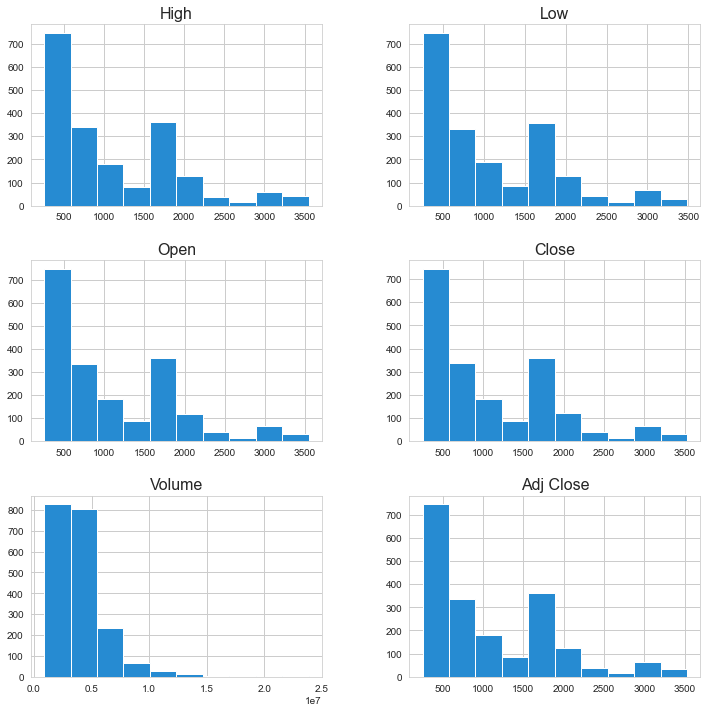

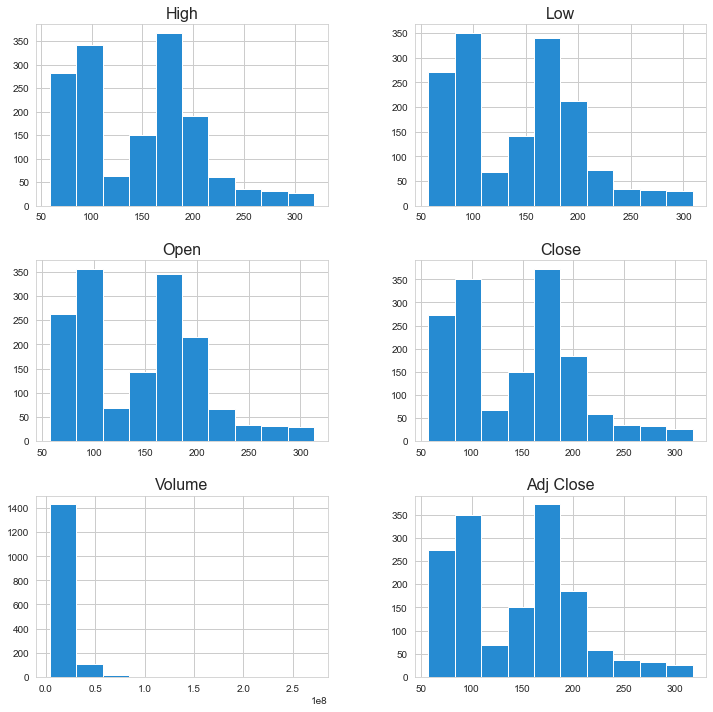

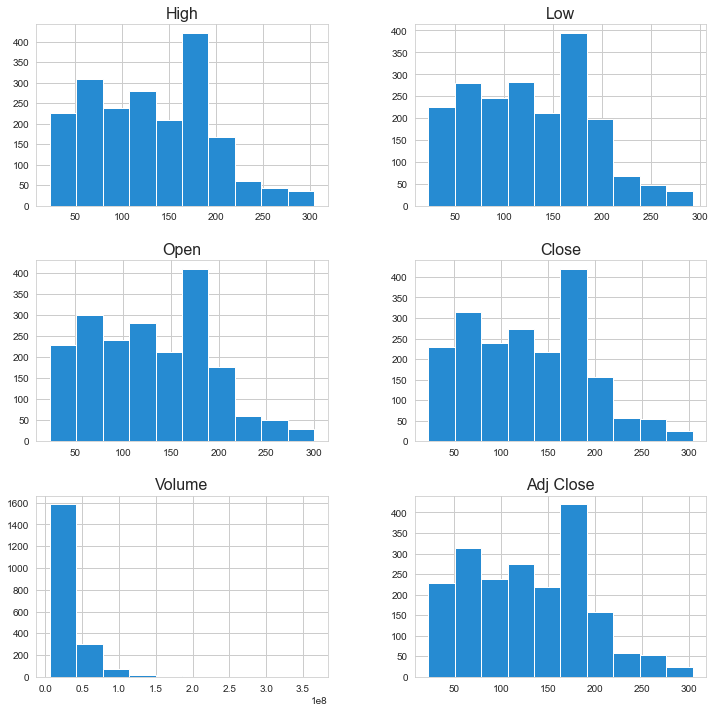

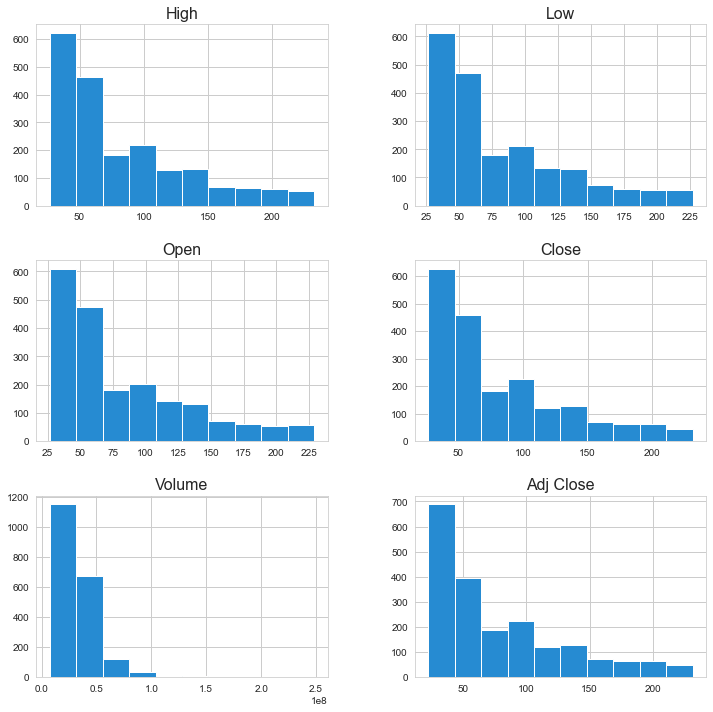

In [13]:
# here we are visualising the additional moving averages
company_data.groupby("company_name").hist(figsize=(12, 12));

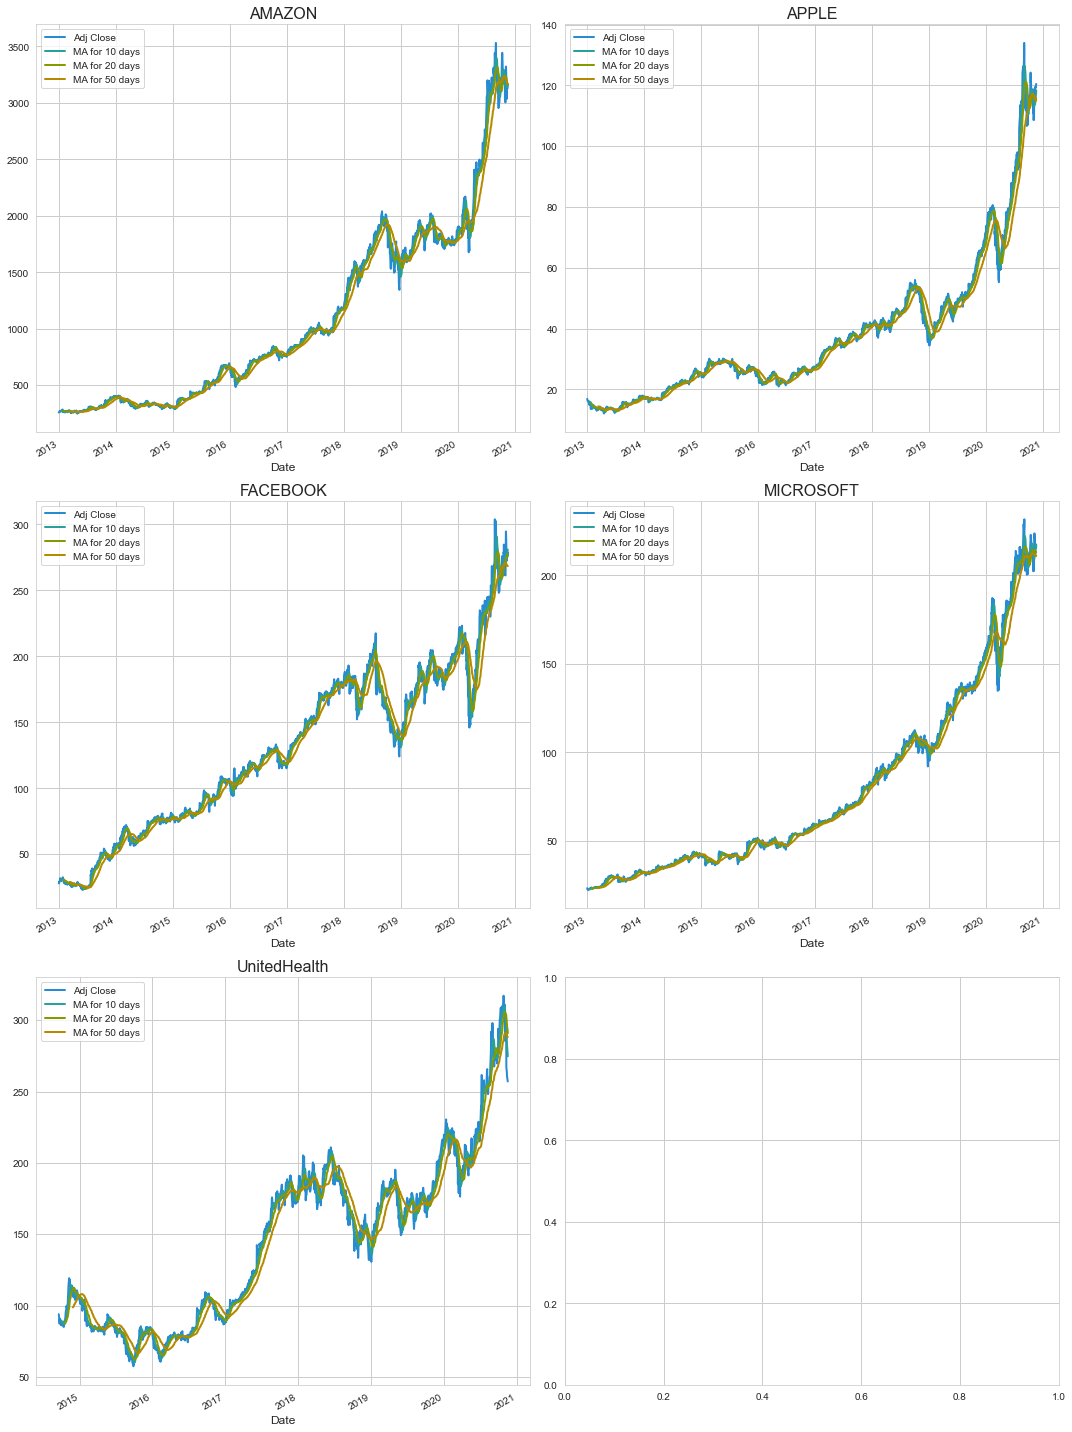

In [14]:
# here we are visualising three important moving averages of all the company
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_figheight(20)
fig.set_figwidth(15)

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('AMAZON')

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('APPLE')

FB[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('FACEBOOK')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('MICROSOFT')

BABA[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[2,0])
axes[2,0].set_title('UnitedHealth')

fig.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

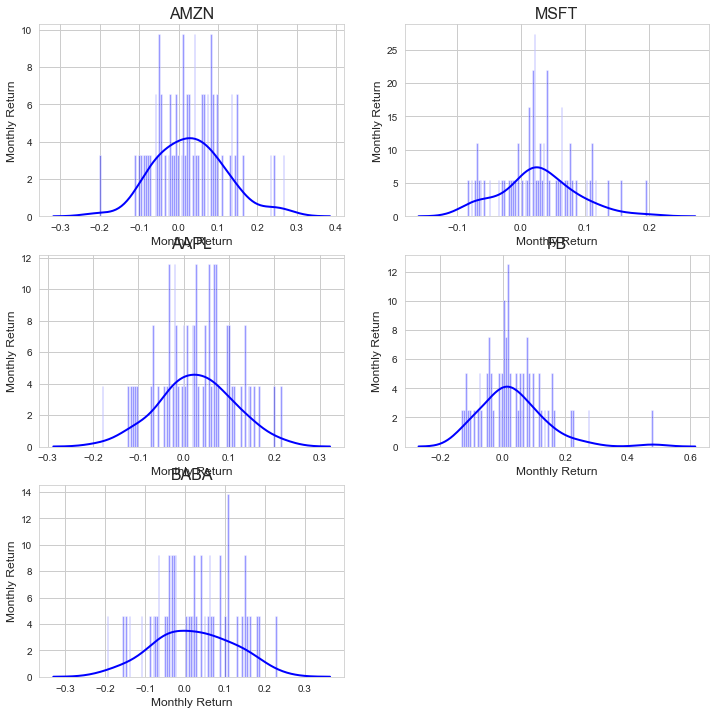

In [15]:
# We'll use pct_change to find the percent change for each month
for company in company_list:
    company['Monthly Return'] = company['Adj Close'].resample('M').ffill().pct_change()

plt.figure(figsize=(12, 12))

for i, company in enumerate(company_list, 1):
    plt.subplot(3, 2, i)
    sns.distplot(company['Monthly Return'].dropna(), bins=100, color='blue')
    plt.ylabel('Monthly Return')
    plt.title(f'{company_name[i - 1]}')

4. What was the correlation between different stocks'?

In [16]:
# Getting Top five company Monthly Adjusted Close price
adjusted_close_five= monthly_adjusted_close[company_name]
adjusted_close_five.head()

Symbols,AMZN,MSFT,AAPL,FB,BABA
Date,,,,,
2015-01-31,354.529999,35.983208,26.465057,75.910004,89.080002
2015-02-28,380.160004,39.333977,29.132116,78.970001,85.120003
2015-03-31,372.100006,36.472504,28.218189,82.220001,83.239998
2015-04-30,421.779999,43.630669,28.381468,78.769997,81.290001
2015-05-31,429.230011,42.307163,29.668266,79.190002,89.320000


In [17]:
# here we are Making DataFrame which is Monthly % change
returns_five= adjusted_close_five.pct_change()
returns_five.head()

Symbols,AMZN,MSFT,AAPL,FB,BABA
Date,,,,,
2015-01-31,NaN,NaN,NaN,NaN,NaN
2015-02-28,0.072293,0.093120,0.100777,0.040311,-0.044454
2015-03-31,-0.021202,-0.072748,-0.031372,0.041155,-0.022087
2015-04-30,0.133512,0.196262,0.005786,-0.041961,-0.023426
2015-05-31,0.017663,-0.030334,0.045339,0.005332,0.098782


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


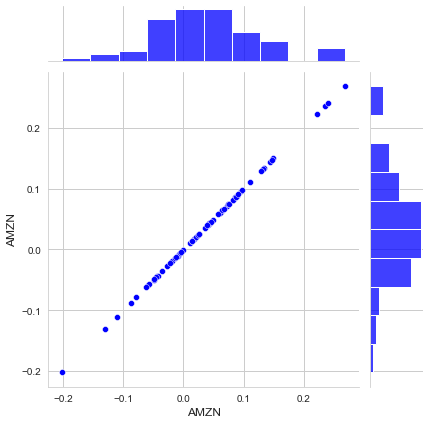

In [18]:
# here we are comparing Amazon to itself should show a perfectly linear relationship
sns.jointplot('AMZN', 'AMZN', returns_five, kind='scatter', color = "blue")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


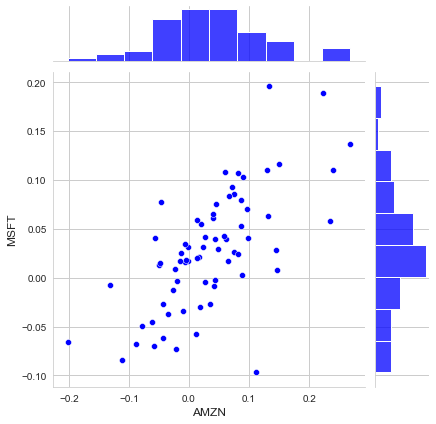

In [19]:
# here We'll use joinplot to compare the daily returns of Amazon and Microsoft
sns.jointplot('AMZN', 'MSFT', returns_five, kind='scatter', color = "blue")

So now we can see that if two stocks are perfectly (and positivley) correlated with each other a linear relationship bewteen its daily return values should occur.

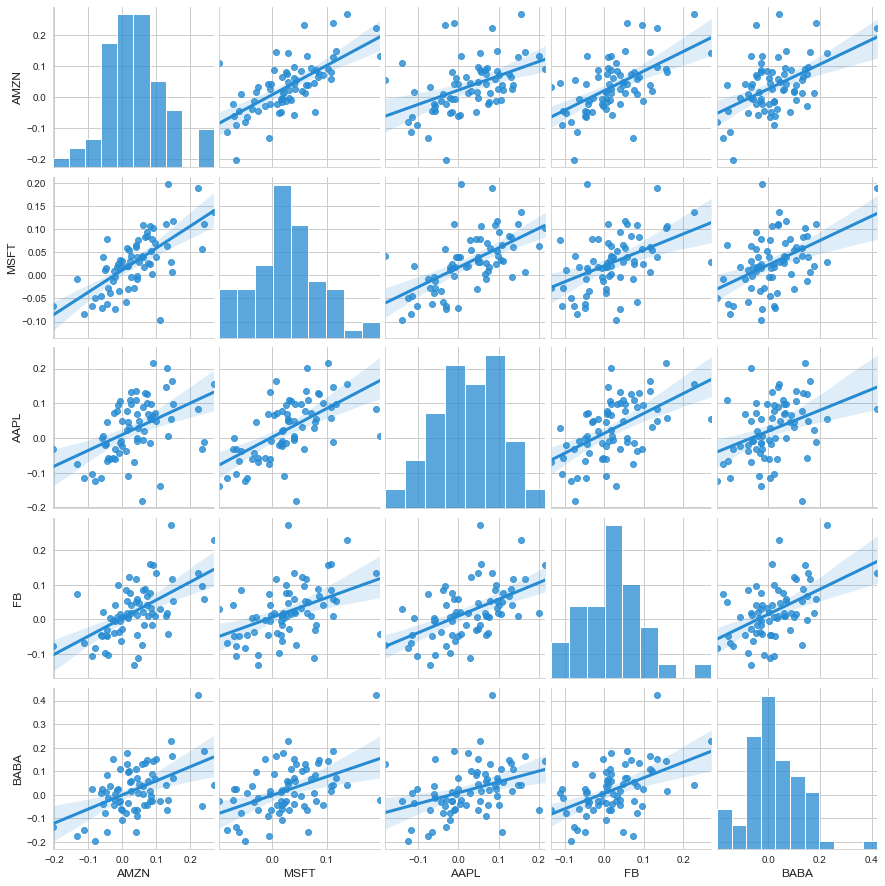

In [20]:
# Here we are simply calling pairplot on our DataFrame for an automatic visual analysis 
# of all the comparisons
sns.pairplot(returns_five, kind='reg')

<AxesSubplot:xlabel='Symbols', ylabel='Symbols'>

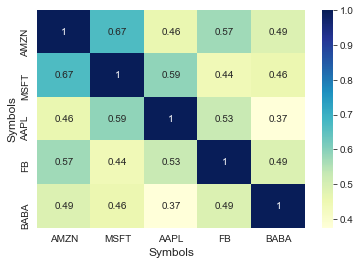

In [21]:
# Here we are using seabron for a quick correlation plot for the daily returns
sns.heatmap(returns_five.corr(), annot=True, cmap="YlGnBu")

5. Portfoilo optimization using Efficient Frontier?

In [22]:
adjusted_close = data['Adj Close'][company_name]
adjusted_close.head()

Symbols,AMZN,MSFT,AAPL,FB,BABA
Date,,,,,
2015-01-02,308.519989,41.647892,24.696352,78.449997,103.599998
2015-01-05,302.190002,41.264908,24.000614,77.190002,101.000000
2015-01-06,295.290009,40.659245,24.002876,76.150002,103.320000
2015-01-07,298.420013,41.175831,24.339447,76.150002,102.129997
2015-01-08,300.459991,42.387146,25.274624,78.180000,105.029999


In [23]:
daily_return = adjusted_close.pct_change()
daily_return.head()

Symbols,AMZN,MSFT,AAPL,FB,BABA
Date,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.020517,-0.009196,-0.028172,-0.016061,-0.025097
2015-01-06,-0.022833,-0.014677,0.000094,-0.013473,0.022970
2015-01-07,0.010600,0.012705,0.014022,0.000000,-0.011518
2015-01-08,0.006836,0.029418,0.038422,0.026658,0.028395


<AxesSubplot:xlabel='Symbols', ylabel='Symbols'>

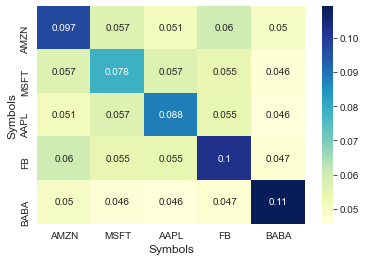

In [24]:
#Analysing of Annual portfiolo return and risk assuming 20% weight on each stock
#assuming trading days = 252 days in a year

weights = np.array([0.2,0.2,0.2,0.2,0.2])

portfolio_return = np.sum(daily_return.mean()* weights)*252
cov_matrix_annual = daily_return.cov()*252
sns.heatmap(cov_matrix_annual, annot=True, cmap="YlGnBu")

In [25]:
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix_annual,weights))
portfolio_std = np.sqrt(portfolio_variance)
risk_free_rate = 0.0178

sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
print("Expected annual return: " + str(round((portfolio_return * 100),2))+'%')
print("Expected Volatility: " + str(round((portfolio_std * 100),2))+'%')
print("Sharpe Ratio: " + str(round((sharpe_ratio),2)))

Expected annual return: 31.06%
Expected Volatility: 24.69%
Sharpe Ratio: 1.19


In [26]:
#calculate mean daily return and covariance of daily returns
mean_daily_returns = daily_return.mean()
cov_matrix = daily_return.cov()

#set number of runs of random portfolio weights
num_portfolios = 25000

In [27]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(5)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [28]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=adjusted_close.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=adjusted_close.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:" + str(round(rp*100,2)) + "%")
    print("Annualised Volatility:" + str(round(sdp*100,2)) + "%")
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:" + str(round(rp_min * 100,2)) + "%")
    print("Annualised Volatility:" + str(round(sdp_min * 100,2)) + "%")
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
   

    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='RdYlBu', marker='o', s=25, alpha=0.3)
    plt.colorbar(label = 'Sharpe ratio')
    plt.scatter(sdp,rp,marker=(5,1,0),color='r',s=100, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker=(5,1,0),color='g',s=100, label='Minimum volatility')

    target = np.linspace(rp_min, 0.42, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='--', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return:40.66%
Annualised Volatility:27.74%


Symbols      AMZN   MSFT   AAPL   FB  BABA
allocation  70.54  11.65  17.81  0.0   0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return:30.52%
Annualised Volatility:24.58%


Symbols      AMZN   MSFT  AAPL    FB   BABA
allocation  14.47  27.75  22.5  13.8  21.48


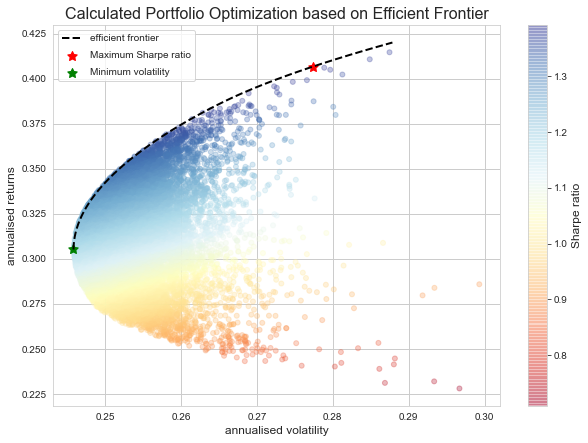

In [29]:
display_calculated_ef_with_random(mean_daily_returns, cov_matrix, num_portfolios, risk_free_rate)

In [30]:
# Calculating the expected returns and the annualised sample covariance matrix of asset returns
mu=expected_returns.mean_historical_return(adjusted_close)
S= risk_models.sample_cov(adjusted_close)

In [31]:
# For minimum volatility
ef=EfficientFrontier(mu,S)
weights=ef.min_volatility()
cleaned_weights=ef.clean_weights()
min_vol_port = ef.portfolio_performance(verbose=True)
print("Allocation of weight")
for x, y in cleaned_weights.items():
    print(x, y)

Expected annual return: 29.8%
Annual volatility: 24.6%
Sharpe Ratio: 1.13
Allocation of weight
AMZN 0.1438
MSFT 0.27873
AAPL 0.22363
FB 0.13728
BABA 0.21657


In [32]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(adjusted_close)
weights = cleaned_weights

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'MSFT': 13, 'AAPL': 19, 'FB': 5, 'BABA': 9}
Funds remaining: $1215.32


6. How much value do we put at risk by investing in a particular stock?

<Figure size 504x360 with 0 Axes>

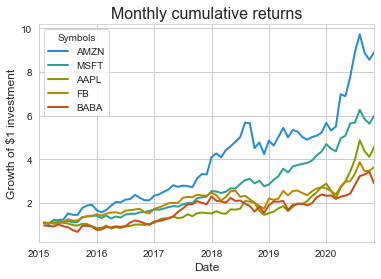

In [33]:
fig = plt.figure(figsize=(7, 5))
(returns_five + 1).cumprod().plot()
plt.xlabel("Date")
plt.ylabel("Growth of $1 investment")
plt.title("Monthly cumulative returns")
plt.show()

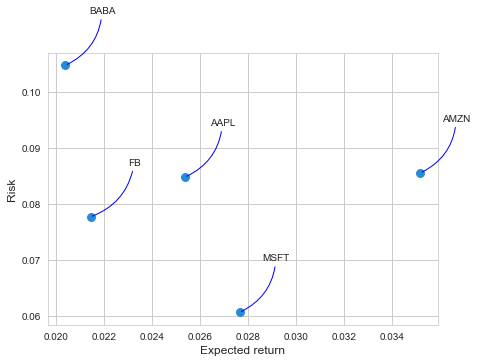

In [34]:
#Here e are defining a new DataFrame as a cleaned version of the original DataFrame
rets = returns_five.dropna()

area = np.pi*20

plt.figure(figsize=(7, 5))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

7. How can we attempt to predict future stock behavior using LSTM?

In [35]:
# Filtering the columns
df = AAPL.iloc[:,0:6]
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,19.821428,19.343929,19.779285,19.608213,560518000.0,16.926661
2013-01-03,19.631071,19.321428,19.567142,19.360714,352965200.0,16.713015
2013-01-04,19.236786,18.779642,19.177500,18.821428,594333600.0,16.247477
2013-01-07,18.903572,18.400000,18.642857,18.710714,484156400.0,16.151909
2013-01-08,18.996071,18.616072,18.900356,18.761072,458707200.0,16.195379


In [36]:
#Data cleaning
df.isna().any()

High         False
Low          False
Open         False
Close        False
Volume       False
Adj Close    False
dtype: bool

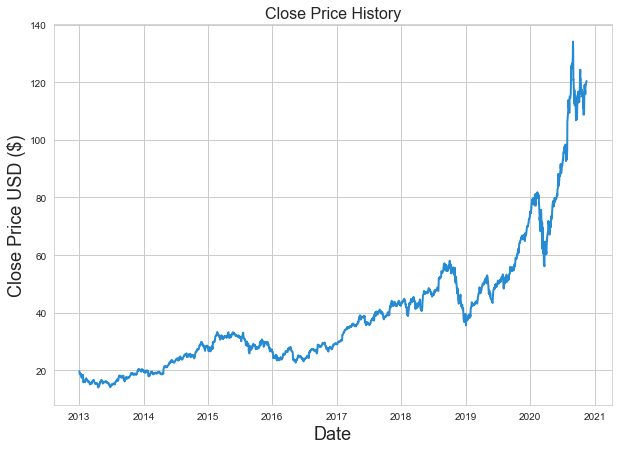

In [37]:
# here we are Visualising the closing price history
plt.figure(figsize=(10,7))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

Create a new data frame with only the closing price and convert it to an array. Then create a variable to store the length of the training data set. I want the training data set to contain about 70% of the data.

In [38]:
#Creating a new dataframe with only the 'Close' column
data = df.filter(['Close'])

#Converting the dataframe to a numpy array
dataset = data.values

#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.7)


Now scale the data set to be values between 0 and 1 inclusive, I do this because it is generally good practice to scale your data before giving it to the neural network.

In [39]:
# Feature Scaling
# here we are Scaling the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [61]:
#Creating the scaled training data set
train_data = scaled_data[0:training_data_len  , : ]

# Creating a data structure with 60 timestep and 1 output
#Spliting the data into x_train and y_train data sets
# Note : Basically what we are trying to do here is take data from day 1 to 60 and make prediction of 61th days

timestep = 60
x_train=[]
y_train = []
for i in range(timestep,len(train_data)):
    x_train.append(train_data[i-timestep:i,0])
    y_train.append(train_data[i,0])
    
#Here we are Converting x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Here we are reshaping the data into the shape accepted by the LSTM
x_train_reshape = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [62]:
# here we are testing data set
test_data = scaled_data[training_data_len - timestep: , : ]
#Creating the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1233 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(timestep,len(test_data)):
    x_test.append(test_data[i-timestep:i,0])
    
    # here we are converting x_test to a numpy array  
x_test = np.array(x_test)

# here we are reshaping the data into the shape accepted by the LSTM  
x_test_reshape = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [63]:
#now we are Building the LSTM network model
# create model
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

#Adding the second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))

#Adding the third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Addding the output layer
model.add(Dense(1))

In [64]:
# Compiling the model
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error')

model.compile(loss='mse', optimizer='adam')

In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_test_reshape, y_test)).batch(batch_size=64)
history = model.fit(
    x_train_reshape,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=val_dataset,
    use_multiprocessing=True
)

Epoch 1/50
21/21 [==============================] - 2s 98ms/step - loss: 0.0046 - val_loss: 4926.8521
Epoch 2/50
21/21 [==============================] - 1s 56ms/step - loss: 6.7136e-04 - val_loss: 4920.4385
Epoch 3/50
21/21 [==============================] - 1s 55ms/step - loss: 3.3897e-04 - val_loss: 4920.2910
Epoch 4/50
21/21 [==============================] - 1s 56ms/step - loss: 2.9760e-04 - val_loss: 4920.7559
Epoch 5/50
21/21 [==============================] - 1s 56ms/step - loss: 3.0756e-04 - val_loss: 4920.2524
Epoch 6/50
21/21 [==============================] - 1s 56ms/step - loss: 2.8233e-04 - val_loss: 4920.0225
Epoch 7/50
21/21 [==============================] - 1s 56ms/step - loss: 2.7099e-04 - val_loss: 4918.6006
Epoch 8/50
14/21 [===================>..........] - ETA: 0s - loss: 2.6567e-04

In [48]:
# now we are getting the models predicted price values
predictions = model.predict(x_test_reshape)

predictions = scaler.inverse_transform(predictions)#Undo scaling


5.884164989258641

<ipython-input-49-c1beac80e8e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


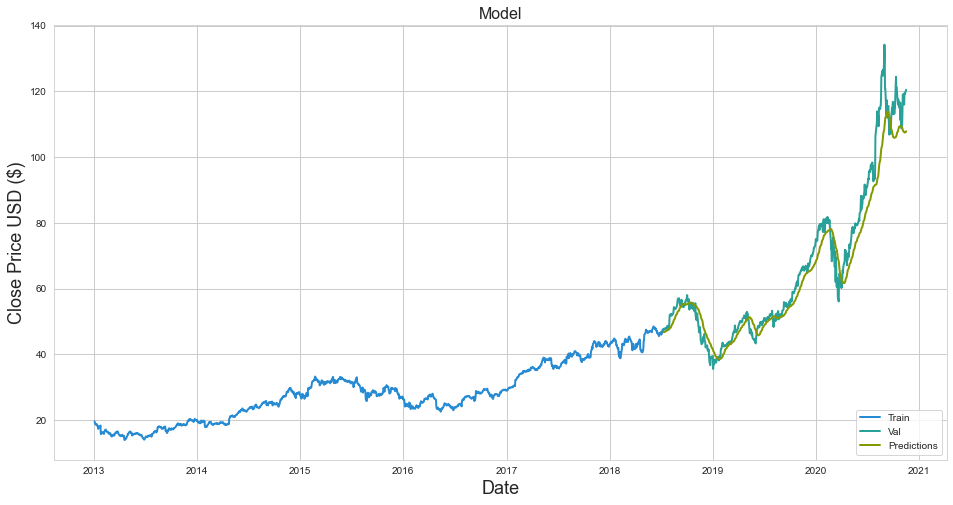

In [49]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<AxesSubplot:xlabel='Date'>

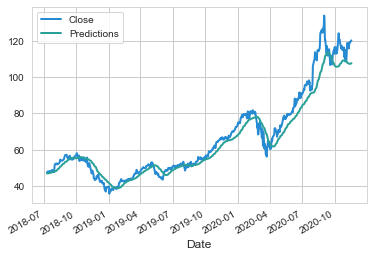

In [50]:
valid.plot()

In [51]:
print('Mean Absolute Error: ',metrics.mean_absolute_error(y_test,predictions))
print('Mean Square Error: ',metrics.mean_squared_error(y_test,predictions))
print('Root Mean Square Error: ',math.sqrt(metrics.mean_squared_error(y_test,predictions)))

Mean Absolute Error:  4.198685833586365
Mean Square Error:  34.62339762081715
Root Mean Square Error:  5.884164989258641


In [52]:
valid.tail()

,Close,Predictions
Date,,
2020-11-11,119.489998,107.467316
2020-11-12,119.209999,107.458359
2020-11-13,119.260002,107.524818
2020-11-16,120.300003,107.658142
2020-11-17,120.464996,107.853172


In [60]:
len(test_data)

655

In [ ]:
x_input = test_data[len(test_data)-60]

In [53]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x_train, y_train)
reg_pred = reg.predict(x_test)


In [54]:
reg_pred = reg_pred.reshape(-1,1)

In [55]:
predictions = scaler.inverse_transform(reg_pred)#Undo scaling

<ipython-input-56-a59e10ae0945>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


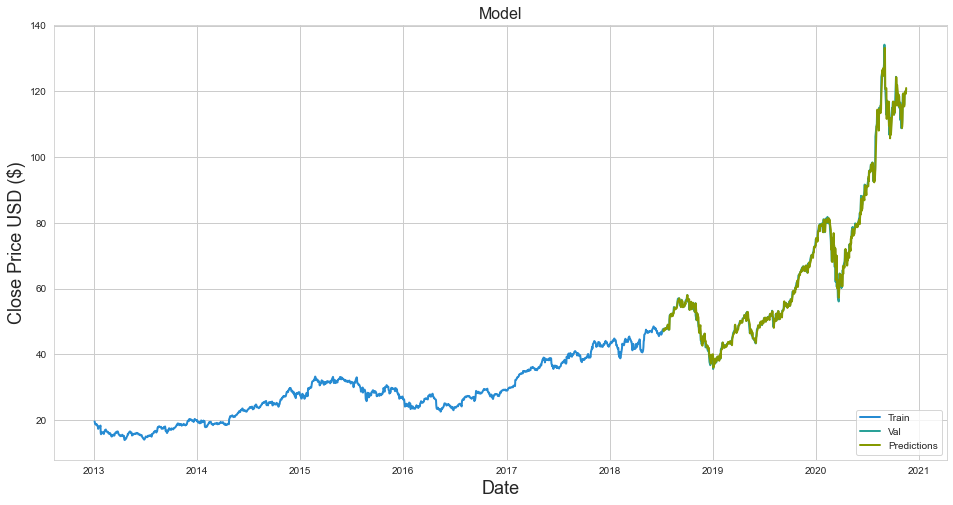

In [56]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

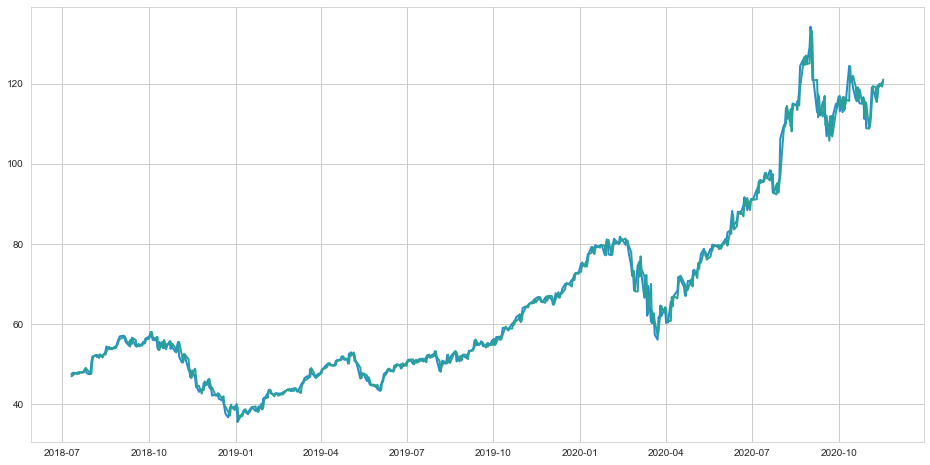

In [57]:
plt.figure(figsize=(16,8))
plt.plot(valid)
plt.show()

In [58]:
print('Mean Absolute Error: ',metrics.mean_absolute_error(y_test,predictions))
print('Mean Square Error: ',metrics.mean_squared_error(y_test,predictions))
print('Root Mean Square Error: ',math.sqrt(metrics.mean_squared_error(y_test,predictions)))

Mean Absolute Error:  1.156153191970672
Mean Square Error:  3.2459720206223808
Root Mean Square Error:  1.8016581308956428


In [59]:
valid.tail()

,Close,Predictions
Date,,
2020-11-11,119.489998,116.441194
2020-11-12,119.209999,119.171650
2020-11-13,119.260002,119.954227
2020-11-16,120.300003,119.249749
2020-11-17,120.464996,120.992373
